<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/main/3_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download the data

In [6]:
df_train = pd.read_csv(f'{manager.data_trial_path}/train_processed.csv', index_col=0)
df_val = pd.read_csv(f'{manager.data_trial_path}/val_processed.csv', index_col=0)
df_test = pd.read_csv(f'{manager.data_trial_path}/test_processed.csv', index_col=0)
df_submission = pd.read_csv(f'{manager.data_trial_path}/submission_processed.csv', index_col=0)

In [7]:
# I forgot to re-insert the original index of submission dataset
submission_index = pd.read_csv(f'{manager.data_root_path}/sample_submission.csv', index_col='id').index
submission_index

Int64Index([22730, 22731, 22732, 22733, 22734, 22735, 22736, 22737, 22738,
            22739,
            ...
            37874, 37875, 37876, 37877, 37878, 37879, 37880, 37881, 37882,
            37883],
           dtype='int64', name='id', length=15154)

In [8]:
X_train = df_train.iloc[:, :-1]
Y_train = df_train.iloc[:, -1]

In [9]:
X_val = df_val.iloc[:, :-1]
Y_val = df_val.iloc[:, -1]

X_test = df_test.iloc[:, :-1]
Y_test = df_test.iloc[:, -1]

X_submission = df_submission.iloc[:, :]

X_trainval = np.vstack([X_train, X_val])
Y_trainval = np.concatenate([Y_train, Y_val])

In [10]:
Xs = [
    X_train,
    X_val,
    X_test,
    X_submission
]

Ys = [
    Y_train,
    Y_val,
    Y_test,
    None
]

# Find the baseline model

## Random forest regressor

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

RANDOM_STATE = 42

rfr_res = GridSearchCV(
    RandomForestRegressor(),
    {
        'n_estimators': [50, 100],
        'random_state': [RANDOM_STATE]
    },
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=5,
    return_train_score=True
)

In [ ]:
rfr_res.fit(
    X=X_trainval,
    y=Y_trainval
)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END n_estimators=50, random_state=42;, score=(train=-15968873.466, test=-49202767.580) total time=   3.7s
[CV 2/3] END n_estimators=50, random_state=42;, score=(train=-17681937.606, test=-17956660.175) total time=   4.4s
[CV 3/3] END n_estimators=50, random_state=42;, score=(train=-5376903.150, test=-158609554.802) total time=   3.7s
[CV 1/3] END n_estimators=100, random_state=42;, score=(train=-14685826.949, test=-47888312.377) total time=   7.9s
[CV 2/3] END n_estimators=100, random_state=42;, score=(train=-15568467.521, test=-17037079.375) total time=   8.4s
[CV 3/3] END n_estimators=100, random_state=42;, score=(train=-5405225.849, test=-155099849.018) total time=   9.6s


GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'n_estimators': [50, 100], 'random_state': [42]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=5)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from model import Model

RandomForestModel = Model(
    RandomForestRegressor(n_estimators=80),
    'RF',
    [
        {
            'n_estimators': [50, 100, 200]
            # other params
        },
    ],
    [
        {
            # Randomized search CV params grid
        },

    ]
)

In [ ]:
all_models = {
    model.name: model
    for model in [
        RandomForestModel,
    ]
}

Model      Seen folds avg score    Seen folds std    Unseen folds avg score    Unseen folds std
-------  ----------------------  ----------------  ------------------------  ------------------
RF                 -1.17635e+07       3.08839e+06              -7.96031e+07         8.40028e+07


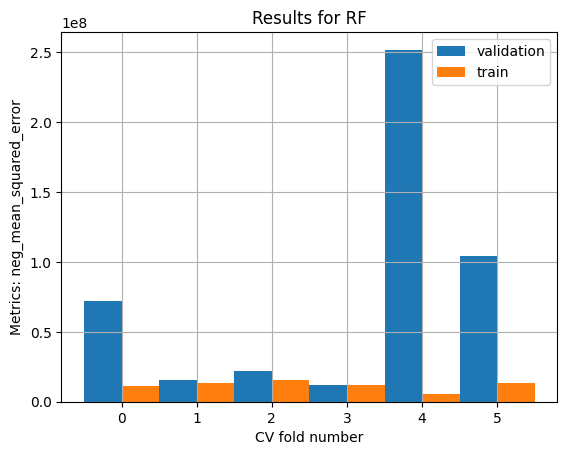

In [ ]:
from sklearn_utils import plot_cv_results

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

res = plot_cv_results(
    sklearn_models_dict_={
        model_name: model.model
        for model_name, model in all_models.items()
    },
    X_=np.vstack([Xs[0], Xs[1]]),
    Y_=np.concatenate([Ys[0], Ys[1]]),
    cv_=6,
    scoring_='neg_mean_squared_error',  # 'accuracy'
    to_put_minus_=True
)

### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rfr_randomized = RandomizedSearchCV(
    RandomForestRegressor(),
    {
        'n_estimators': np.arange(1, 200),
        # 'max_depth':
    }

)

### GridSearchCV

In [ ]:
from sklearn_utils import dict_subset
from sklearn_utils import (
    fit_grid_search,
    fit_randomized_search
)

rf_gridsearch_results = fit_grid_search(
    dict_subset(all_models, ['RF']),
    X_=X_trainval,
    Y_=Y_trainval,
    cv_=4,
    scoring_='neg_mean_squared_error'
)

Fitting RF


KeyboardInterrupt: ignored

# Make predictions with the best model

## Final report

In [12]:
from sklearn.ensemble import RandomForestRegressor


best_model = RandomForestRegressor(n_estimators=100)
best_model.fit(X_train, Y_train)

RandomForestRegressor()

In [13]:
from sklearn.metrics import mean_squared_error

def report_model(model, X, Y):
    preds = model.predict(X)
    print(mean_squared_error(y_true=Y, y_pred=preds, squared=False))

report_model(best_model, X_train, Y_train)
report_model(best_model, X_val, Y_val)

3864.0781926484956
9275.468510959081


## Retrain on all available data

In [14]:
best_model.fit(
    np.vstack([X_train, X_val, X_test]),
    np.concatenate([Y_train, Y_val, Y_test])
)

RandomForestRegressor()

# Predict and save predictions

In [15]:
submission_preds = best_model.predict(X_submission)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [17]:
submission_df = pd.DataFrame(
    {
        'price': submission_preds
    },
    index=submission_index
)
submission_df.head()

,price
id,
22730,4766771.297
22731,6218928.697
22732,9067881.849
22733,1645092.698
22734,6758988.588


In [19]:
submission_df.to_csv(
    f'{manager.data_trial_path}/submission_rfr_17_10_23.csv',
    index=True
)